In [2]:
from google.cloud import bigquery
import pandas as pd
import seaborn as sns
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
sns.set()

In [3]:
tone_df = pd.read_csv("../data/gkg_apr_2020_sample_topic.csv", usecols=["DATE", "topic", "TONE", "POSITIVE_SCORE", "NEGATIVE_SCORE", "POLARITY"])

In [4]:
tone_df = tone_df.astype({"DATE":"datetime64", "topic":"category", "TONE":float, "POSITIVE_SCORE":float, "NEGATIVE_SCORE":float, "POLARITY":float})
tone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924653 entries, 0 to 924652
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DATE            924653 non-null  datetime64[ns]
 1   TONE            924653 non-null  float64       
 2   POSITIVE_SCORE  924653 non-null  float64       
 3   NEGATIVE_SCORE  924653 non-null  float64       
 4   POLARITY        924653 non-null  float64       
 5   topic           924653 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(4)
memory usage: 36.2 MB


In [5]:
pd.merge(tone_df.groupby("topic").mean(), tone_df.groupby("topic")["TONE"].count().rename("COUNT"), left_index=True, right_index=True)

,TONE,POSITIVE_SCORE,NEGATIVE_SCORE,POLARITY,COUNT
topic,,,,,
1,-2.019167,2.881265,4.900432,7.781697,216466
2,-2.226005,2.780474,5.006480,7.786954,103045
3,-0.898475,2.734095,3.632570,6.366666,45708
4,-2.559697,2.390827,4.950524,7.341351,104934
5,-0.947997,2.862938,3.810935,6.673872,65016
6,-0.354583,2.882793,3.237377,6.120170,92104
7,-0.814095,2.975652,3.789747,6.765399,182450
8,-0.282378,3.123819,3.406197,6.530016,114930


In [6]:
def calculate_daily_average(df):
    return df.groupby(["topic", "DATE"])[["TONE", "POSITIVE_SCORE", "NEGATIVE_SCORE", "POLARITY"]].mean().reset_index(level="topic")

def calculate_first_diff(df):
    df = df.sort_index()
    return df[["TONE", "POSITIVE_SCORE", "NEGATIVE_SCORE", "POLARITY"]].diff().dropna()
     
tone_daily = calculate_daily_average(tone_df)
tone_diff = tone_daily.groupby("topic").apply(calculate_first_diff).reset_index(level="topic")
tone_diff

,topic,TONE,POSITIVE_SCORE,NEGATIVE_SCORE,POLARITY
DATE,,,,,
2020-04-02,1,-0.004426,-0.015572,-0.011146,-0.026718
2020-04-03,1,0.174350,0.068721,-0.105629,-0.036908
2020-04-06,1,-0.274426,-0.100394,0.174031,0.073637
2020-04-07,1,0.283141,0.171326,-0.111815,0.059510
2020-04-08,1,-0.075495,-0.037982,0.037513,-0.000468
...,...,...,...,...,...
2020-04-24,8,0.240924,0.174827,-0.066097,0.108730
2020-04-27,8,-0.129624,-0.024764,0.104861,0.080097
2020-04-28,8,0.044989,-0.043801,-0.088790,-0.132591


In [7]:
client = bigquery.Client()

query="""
SELECT * from goldenfleece.sentiment.ftse100 order by Date
"""
ftse_df = client.query(query).to_dataframe()
ftse_df.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2019-09-20,7356.399902,7376.299805,7322.000000,7344.899902,7344.899902,1656288000
1,2019-09-23,7344.899902,7362.299805,7284.799805,7326.100098,7326.100098,489660300
2,2019-09-24,7326.100098,7349.000000,7281.899902,7291.399902,7291.399902,588772200
3,2019-09-25,7291.399902,7292.000000,7213.000000,7290.000000,7290.000000,704553100
4,2019-09-26,7290.000000,7387.100098,7277.200195,7351.100098,7351.100098,704707500


In [8]:
ftse_df = ftse_df.astype({"Date":"datetime64"}).set_index("Date") 
ftse_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2019-09-20 to 2020-11-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       300 non-null    float64
 1   High       300 non-null    float64
 2   Low        300 non-null    float64
 3   Close      300 non-null    float64
 4   Adj_Close  300 non-null    float64
 5   Volume     300 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 16.4 KB


In [9]:
adj_close = ftse_df.sort_index()["Adj_Close"]
adj_close_diff = adj_close.diff()

<AxesSubplot:xlabel='Date'>

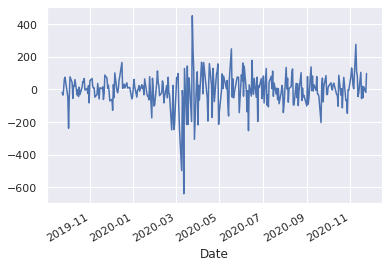

In [10]:
adj_close_diff.plot()

In [11]:
merged_df = tone_diff.merge(adj_close_diff, left_index=True, right_index=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 152 entries, 2020-04-02 to 2020-04-30
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   topic           152 non-null    category
 1   TONE            152 non-null    float64 
 2   POSITIVE_SCORE  152 non-null    float64 
 3   NEGATIVE_SCORE  152 non-null    float64 
 4   POLARITY        152 non-null    float64 
 5   Adj_Close       152 non-null    float64 
dtypes: category(1), float64(5)
memory usage: 7.6 KB


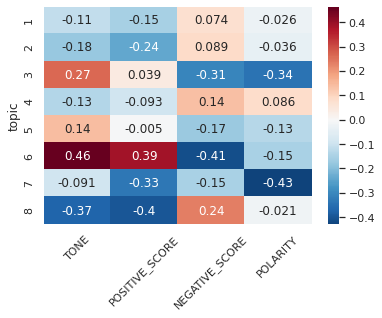

In [12]:
corr_df = merged_df.groupby("topic").corr(method="pearson")["Adj_Close"].drop(index="Adj_Close", level=1).unstack()

ax = sns.heatmap(corr_df, cmap='RdBu_r', center=0, annot=True)
plt.xticks(rotation=45);

In [55]:
ax.figure.savefig("correlation_heatmap.png", bbox_inches="tight")

<IPython.core.display.Javascript object>

#### Take the first difference of each time series and plot scatterplots

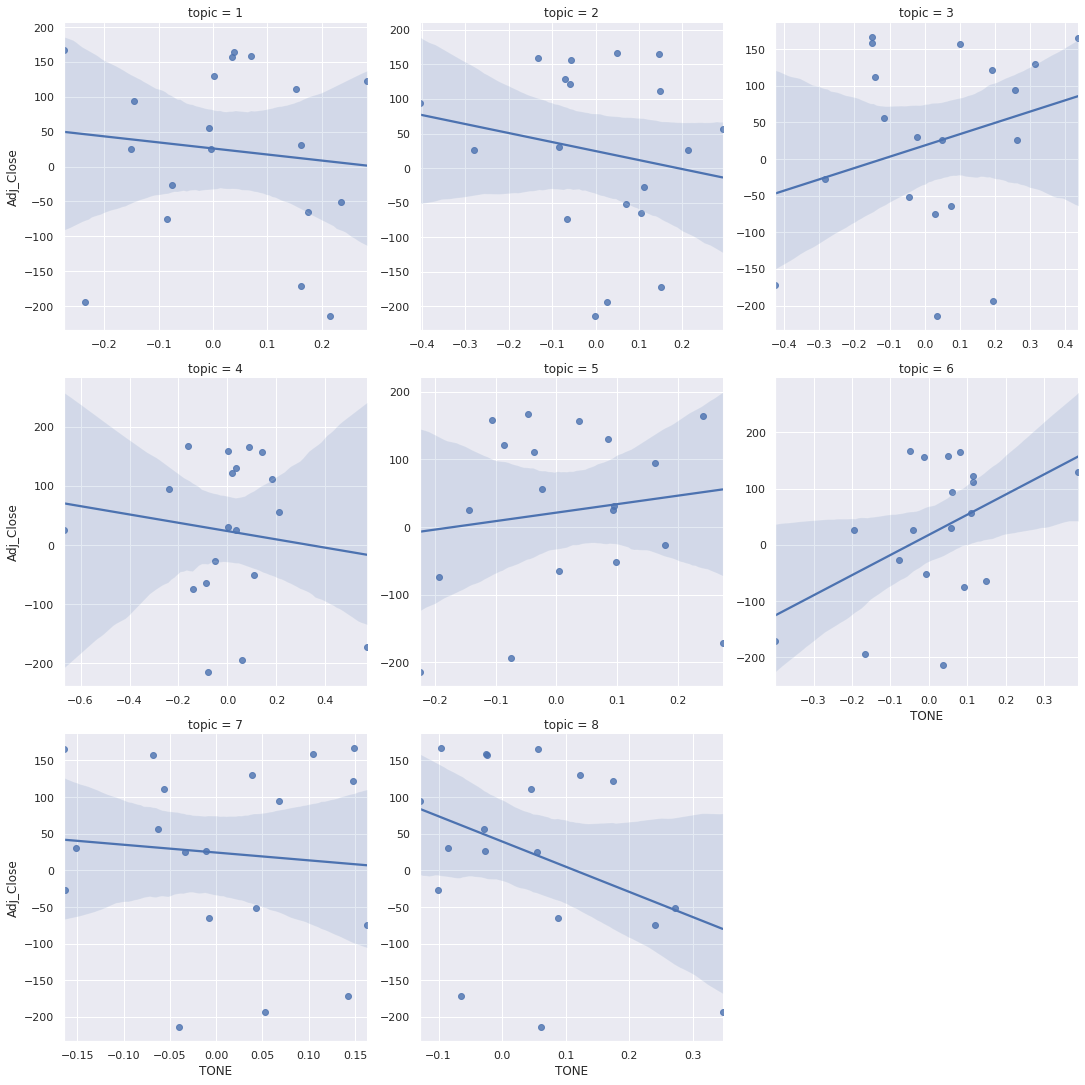

In [13]:
sns.lmplot(x="TONE", y="Adj_Close", data=merged_df, col="topic", col_wrap=3, sharex=False, sharey=False)

### Investigate cross correlation across topic 6

In [16]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

merged_df_1 = merged_df[merged_df.topic == 6]
tone_cross_correlation = {lag:crosscorr(merged_df_1["TONE"], merged_df_1["Adj_Close"], lag) for lag in range(-10, 10)}

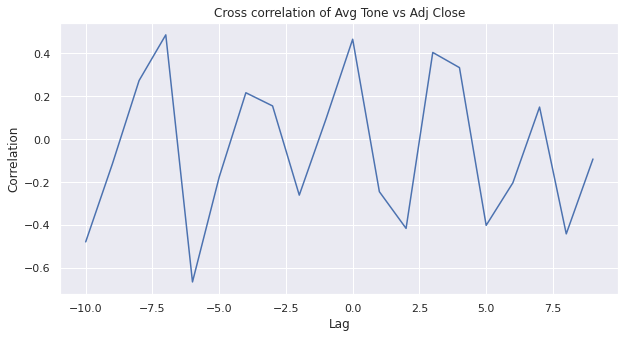

In [17]:
ax = pd.Series(tone_cross_correlation).plot(figsize=(10,5))
ax.set_xlabel("Lag")
ax.set_ylabel("Correlation")
ax.set_title("Cross correlation of Avg Tone vs Adj Close");